# **CNN | Classification**

Now that we've extracted features from each audio file, we'll move on to the next crucial step: **classifying emotions using a Convolutional Neural Network** (CNN). Our model will learn to recognize patterns in the extracted features, allowing it to accurately distinguish between different emotional states present in the speech data.

## **Load packages**

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from keras.callbacks import ModelCheckpoint, EarlyStopping,ReduceLROnPlateau
from keras.layers import Flatten, Dropout, Conv1D, MaxPooling1D, Dense, Input

import tensorflow.keras.layers as L
from tensorflow.keras.models import load_model

## **Load dataset**

In [2]:
data = np.load('./features_npz/features_no.npz')

In [3]:
X = data['X']
labels = data['Y']

In [4]:
print(f"Size of features: {X.shape}")
print(f"Size of labels: {labels.shape}")

Size of features: (12162, 2376)
Size of labels: (12162,)


In [5]:
np.unique(labels) # we've considered calm == neutral

array(['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'],
      dtype='<U8')

## **Custom dataset**

In the `labels` array, we have words representing different emotions (e.g., "happy," "sad," "angry"). However, CNNs work with numerical data rather than raw text.  

To make our dataset compatible with the model, we need to transform these categorical labels into a numerical format. One common approach is **One-Hot Encoding**, which converts each label into a binary vector where only one position is `1` (representing the corresponding class), and all other positions are `0`. 

In [6]:
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(labels).reshape(-1,1)).toarray()

With all of this done, we are now ready to split the dataset into training and testing sets. We'll use **80% of the data for training** and **20% for testing** to ensure that our model learns effectively while still being evaluated on unseen data.

In [7]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=42,test_size=0.2, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((9729, 2376), (9729, 7), (2433, 2376), (2433, 7))

The following code reshapes the training and testing data to be compatible with **CNN**:

In [8]:
X_train = x_train.reshape(x_train.shape[0] , x_train.shape[1] , 1)
X_test = x_test.reshape(x_test.shape[0] , x_test.shape[1] , 1)

To improve the performance of our **CNN model**, we standardize the features using **StandardScaler**

In [9]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [10]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((9729, 2376), (9729, 7), (2433, 2376), (2433, 7))

## **CNN - Model**

### **Callbacks**

When training a **CNN model**, we use **callbacks** to optimize training and improve model performance. Two common callbacks are:

- **Model Checkpoint:** Prevents overfitting by keeping only the best model, and saves the best model weights based on accuracy.

- **ReduceLROnPlateau:** Helps avoid getting stuck in local minima by adjusting the learning rate dynamically.


In [11]:
model_checkpoint = ModelCheckpoint('./weights/weights_no.keras', monitor='val_accuracy', save_best_only=True)
lr_reduction=ReduceLROnPlateau(monitor='val_accuracy',patience=3,verbose=1,factor=0.5,min_lr=0.00001)

CNNs expect **3D input data** in the format **(samples, features, channels)**. However, extracted features from audio are typically **2D** (samples, features), that's why we're going to add an extra channel dimension to our dataset.

In [12]:
x_train_cnn = np.expand_dims(x_train, axis=2)
x_test_cnn = np.expand_dims(x_test, axis=2)

x_train_cnn.shape, y_train.shape, x_test_cnn.shape, y_test.shape

((9729, 2376, 1), (9729, 7), (2433, 2376, 1), (2433, 7))

### **Model implementation**

In [13]:
model = tf.keras.Sequential([

    Input(shape=(X_train.shape[1],1)),

    Conv1D(256, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    
    Conv1D(128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    
    Conv1D(64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    
    Conv1D(64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    
    Conv1D(32, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(7, activation='softmax') 
])

model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 2374, 256)      │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 1187, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 1185, 128)      │        98,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 592, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 592, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 590, 64)        │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 295, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 295, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 293, 64)        │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 146, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 144, 32)        │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 72, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 734,503 (2.80 MB)

 Trainable params: 734,503 (2.80 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
history = model.fit(
                    x_train_cnn, 
                    y_train, 
                    epochs=30, 
                    validation_data=(x_test_cnn, y_test), 
                    batch_size=64, 
                    callbacks=[lr_reduction,model_checkpoint]
                )

Epoch 1/30
153/153 ━━━━━━━━━━━━━━━━━━━━ 104s 662ms/step - accuracy: 0.2442 - loss: 1.8109 - val_accuracy: 0.3859 - val_loss: 1.5799 - learning_rate: 0.0010
Epoch 2/30
153/153 ━━━━━━━━━━━━━━━━━━━━ 103s 672ms/step - accuracy: 0.4030 - loss: 1.4945 - val_accuracy: 0.4838 - val_loss: 1.3277 - learning_rate: 0.0010
Epoch 3/30
153/153 ━━━━━━━━━━━━━━━━━━━━ 101s 662ms/step - accuracy: 0.4730 - loss: 1.3408 - val_accuracy: 0.4702 - val_loss: 1.3480 - learning_rate: 0.0010
Epoch 4/30
153/153 ━━━━━━━━━━━━━━━━━━━━ 100s 656ms/step - accuracy: 0.5163 - loss: 1.2332 - val_accuracy: 0.5105 - val_loss: 1.2581 - learning_rate: 0.0010
Epoch 5/30
153/153 ━━━━━━━━━━━━━━━━━━━━ 101s 658ms/step - accuracy: 0.5437 - loss: 1.1721 - val_accuracy: 0.4727 - val_loss: 1.3124 - learning_rate: 0.0010
Epoch 6/30
153/153 ━━━━━━━━━━━━━━━━━━━━ 103s 676ms/step - accuracy: 0.5525 - loss: 1.1430 - val_accuracy: 0.5146 - val_loss: 1.2112 - learning_rate: 0.0010
Epoch 7/30
153/153 ━━━━━━━━━━━━━━━━━━━━ 106s 695ms/step - accura

We're going to plot how loss and accuracy have improved over the epochs

77/77 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 0.5528 - loss: 2.1944
Accuracy of our model on test data :  55.11714220046997 %


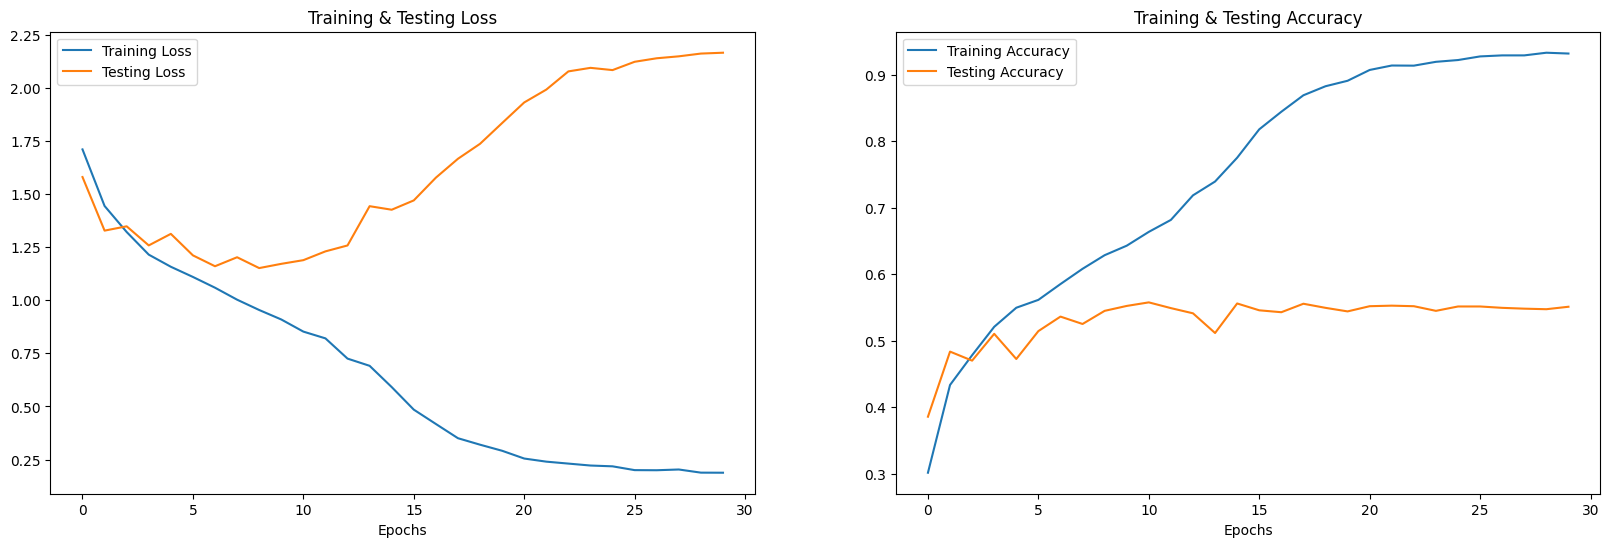

In [15]:
print("Accuracy of our model on test data : " , model.evaluate(x_test_cnn,y_test)[1]*100 , "%")

epochs = [i for i in range(30)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

## **Metrics**

Now that we have trained the model, we will evaluate its performance by calculating some metrics.

- Accuracy
- Precision
- Recall
- F1 score

### **Load packages**

In [16]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score
import seaborn as sns

### **Load Model**

As we saved the best weights in a `.h5` file, we're going to load them into the model architecture.

In [17]:
hyperparams = './weights/weights_no.keras'
mod = load_model(hyperparams)

In [18]:
y_pred = mod.predict(x_test_cnn)
y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

77/77 ━━━━━━━━━━━━━━━━━━━━ 10s 123ms/step


In [19]:
# F1-score
f1 = f1_score(y_test_labels, y_pred_labels, average='weighted')  
print("F1-score:", f1)

# Accuracy
accuracy = accuracy_score(y_test_labels, y_pred_labels)
print("Accuracy:", accuracy)

# Precision
precision = precision_score(y_test_labels, y_pred_labels, average='weighted')
print("Precision:", precision)

# Recall
recall = recall_score(y_test_labels, y_pred_labels, average='weighted')
print("Recall:", recall)


F1-score: 0.5521815469717953
Accuracy: 0.5577476366625566
Precision: 0.5719352793403517
Recall: 0.5577476366625566


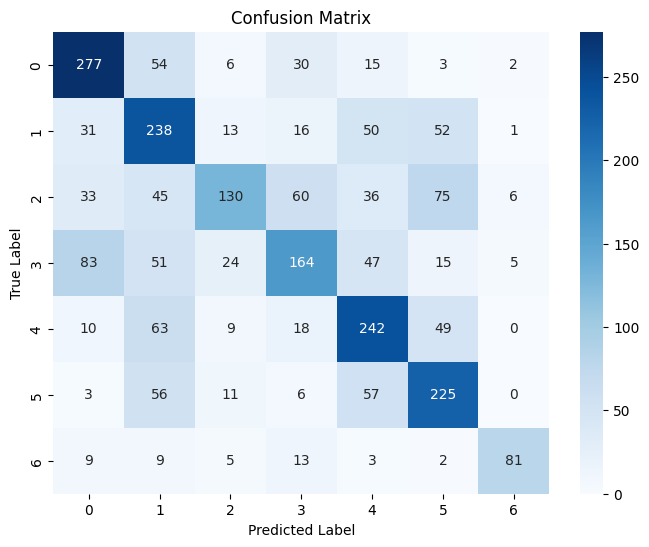

In [20]:
conf_matrix = confusion_matrix(y_test_labels, y_pred_labels)

plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range(7), yticklabels=range(7))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()